# Step 1 : Whisper

In [1]:
import whisper
import pandas as pd
import os
import csv
import numpy as np
import ast
import re
from pathlib import Path
from tqdm import tqdm
from difflib import SequenceMatcher



## I. Transcribing audio files

In [2]:
def transcribe_audio(csv_path, audio_folder, output_csv="segments_par_audio.csv", model_name="small", lang="it"):
    """
    Transcribes each audio file with Whisper (word_timestamps=True)
    and adds to DataFrame a single line per file, in the format : [["word", [time_start, time_end]], ...]
    """
    df_files = pd.read_csv(csv_path)

    if "file_name" not in df_files.columns:
        raise ValueError("Column 'file_name' not in CSV.")

    model = whisper.load_model(model_name)
    results = []

    for file_name in tqdm(df_files["file_name"], desc="Transcribing..."):
        audio_path = Path(audio_folder) / file_name

        if not audio_path.exists():
            print(f"❌ File not found : {audio_path}")
            results.append({"file_name": file_name, "segments": []})
            continue

        result = model.transcribe(str(audio_path), word_timestamps=True, language=lang)

        word_segments = []
        for segment in result["segments"]:
            for word in segment.get("words", []):
                word_segments.append([
                    word["word"].strip(),
                    [round(word["start"], 2), round(word["end"], 2)]
                ])

        results.append({
            "file_name": file_name,
            "segments": word_segments
        })

    # Créer le DataFrame final
    df_result = pd.DataFrame(results)
    df_result["segments"] = df_result["segments"].apply(lambda x: str(x))  # pour sauvegarde lisible
    df_result["len_segments"] = df_result["segments"].apply(lambda x: len(eval(x))) 
    df_result.to_csv(output_csv, index=False)
    print(f"✅ CSV exported : {output_csv}")
    return df_result


In [ ]:
# ===== CSV with all data =====

csv_path = "/pvc/scratch/speech_recognition/Hackathon_ASR/1_Ground_truth/Decoding_ground_truth_IT.csv"
df_ground_truth = pd.read_csv(csv_path)


# ===== Audio folder =====

audio_folder = "/pvc/scratch/speech_recognition/Hackathon_ASR/2_Audiofiles/Decoding_IT_T1"


# ===== To test with a small sample =====
csv_sample = "first_5_rows.csv"
df_ground_truth.head()
df_ground_truth.head(5).to_csv(csv_sample, index=False)




In [ ]:
df = transcribe_audio(
    csv_path = csv_path,
    audio_folder = audio_folder,
    output_csv = "transcribed.csv",
    model_name = "small",
    lang = "it"
)

# 

## II. Clean Output

### Utility Cleaning Functions

In [3]:

# --- Cleaning Functions ---

def clean_punctuation(words):
    cleaned = []
    for item in words:
        if isinstance(item, list) and len(item) == 2:
            word, times = item
            word_cleaned = re.sub(r'[.,]+$', '', word)         # remove trailing punctuation
            word_cleaned = re.sub(r'\.{3,}', '', word_cleaned) # remove long dots
            cleaned.append([word_cleaned, times])
        else:
            cleaned.append(item)
    return cleaned

def check_stutter(words):
    cleaned_words = []
    for i in range(len(words) - 1):
        current = words[i][0].strip()
        nxt = words[i + 1][0].strip()
        if nxt.startswith(current):
            continue
        cleaned_words.append(words[i])
    cleaned_words.append(words[-1])
    return cleaned_words

def check_repetition(words):
    cleaned_words = []
    for i in range(len(words) - 1):
        current = words[i][0].strip()
        nxt = words[i + 1][0].strip()
        if current == nxt:
            continue
        cleaned_words.append(words[i])
    cleaned_words.append(words[-1])
    return cleaned_words

def concatenate_words(words):
    concatenated = []
    skip = False
    for i in range(len(words) - 1):
        if skip:
            skip = False
            continue
        word, time = words[i]
        next_word, next_time = words[i + 1]
        if len(word.strip()) <= 2:
            new_word = word.strip() + next_word.strip()
            new_time = [time[0], next_time[1]]
            concatenated.append([new_word, new_time])
            skip = True
        else:
            concatenated.append([word, time])
    if not skip:
        concatenated.append(words[-1])
    return concatenated

def clean_output(words):
    if not words:
        return words
    words = clean_punctuation(words)
    words = check_repetition(words)
    words = check_stutter(words)
    words = concatenate_words(words)
    return words

# --- Filter and clean segments column ---

def filter_segments(segments):
    return [
        [word, timestamps] 
        for word, timestamps in segments 
        if not (len(word) <= 5 and "..." in word)
    ]

def safe_filter_segments(row):
    try:
        original = ast.literal_eval(row['segments'])
        filtered = filter_segments(original)
        if filtered != original:
            return filtered
        return None
    except Exception as e:
        print(f"Error in row: {row['file_name']}\n{e}")
        return None


# ===== Clean segments ====

def clean_reponse(reponse):
    if isinstance(reponse, list):
        reponse = " ".join(reponse)
    reponse = re.sub(r"[{}.\[\]]", " ", reponse)  # remove special punctuation
    reponse = re.sub(r"[^a-zA-Zàèéìòùç\s]", "", reponse)  # keep only letters and spaces
    mots = reponse.lower().split()
    return mots

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

def correct_segments(segments, config_list):
    if isinstance(segments, str):
        try:
            segments = ast.literal_eval(segments)
        except:
            return []

    mots_ref = clean_reponse(config_list)

    if len(segments) < 12:
        return []
    elif len(segments) == 12:
        return segments

    mots_whisper = [mot[0].lower() for mot in segments]

    scores = []
    for i, mot_w in enumerate(mots_whisper):
        score_total = sum(similarity(mot_w, mot_ref) for mot_ref in mots_ref)
        scores.append((i, score_total))

    meilleurs = sorted(scores, key=lambda x: x[1], reverse=True)[:12]
    indices_gardes = sorted([i for i, _ in meilleurs])

    segments_corriges = [segments[i] for i in indices_gardes]
    return segments_corriges





# --- Full cleaning process applied to segments column ---

def clean_segments_column(df):
    df = df.copy()

    def process_row(segment_str):
        try:
            parsed = ast.literal_eval(segment_str)
            filtered = filter_segments(parsed)
            cleaned = clean_output(filtered)
            return str(cleaned)
        except Exception as e:
            print(f"Error processing row: {segment_str}\n{e}")
            return segment_str  # fallback

    df['segments'] = df['segments'].apply(process_row)

    df['len_segments'] = df['segments'].apply(
        lambda x: len(ast.literal_eval(x)) if x and x != '[]' else 0
    )

    return df

def french_clean(df):
    """
    Only keep rows where the 'segments' column contains exactly one word.
    Assumes 'segments' is a stringified list of [word, [start, end]] elements.
    """
    def has_one_segment(segment_str):
        try:
            segments = ast.literal_eval(segment_str)
            return isinstance(segments, list) and len(segments) == 1
        except:
            return False  # Skip rows with malformed segments

    df_filtered = df[df['segments'].apply(has_one_segment)].copy()
    return df_filtered

def italian_clean(df):
    """
    Only keep rows where the 'segments' column contains exactly 12 words.
    """
    def keep(segment_str):
        try:
            segments = ast.literal_eval(segment_str)
            return isinstance(segments, list) and len(segments) == 12
        except:
            return False  # Skip rows with malformed segments

    df_filtered = df[df['segments'].apply(keep)].copy()
    return df_filtered
    

### --- Main function to clean the entire CSV file ---
def clean_data(file_name, language=None):
    """
    Cleans the CSV file by applying various cleaning functions to the 'segments' column.

    file_name (str): The path to the CSV file.
    language (str): The language of the data. Can be "FR" or "IT" (None will remove no rows)
    """
    df = pd.read_csv(file_name)
    df = clean_segments_column(df)
    if language == "FR":
        df = french_clean(df)
    if language == "IT":
        df = italian_clean(df)
    return df

### Apply Cleaning Pipeline To Transcribed Files

In [35]:
file_name = "/Users/melina/Desktop/Hackathon/Lemanic-Life-Sciences-Hackathon-2025/Segment_medium_IT_not_cleaned.csv"
df_original = pd.read_csv(file_name)
df_cleaned = clean_data(file_name, "IT")
df_cleaned.head(5)

,file_name,segments,len_segments
0,1001_edugame2023_59aa8ecf74c44db2adf56d71d1705...,"[['Vuso', [1.86, 3.26]], ['Seca', [3.76, 4.18]...",12
1,1001_edugame2023_59aa8ecf74c44db2adf56d71d1705...,"[['Istroppi', [1.54, 4.06]], ['insmog', [4.06,...",12
2,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[['strade', [4.1, 5.5]], ['minestra', [6.1, 7....",12
3,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[['diva', [2.04, 3.44]], ['notte', [3.52, 4.3]...",12
5,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[['Scarpa', [2.76, 4.08]], ['filio', [4.36, 5....",12


### Save Cleaned Data

In [36]:
# save the cleaned df
df_cleaned.to_csv("/Users/melina/Desktop/Hackathon/Lemanic-Life-Sciences-Hackathon-2025/Segment_medium_IT_cleaned.csv", index=False)

### Visualize distribution

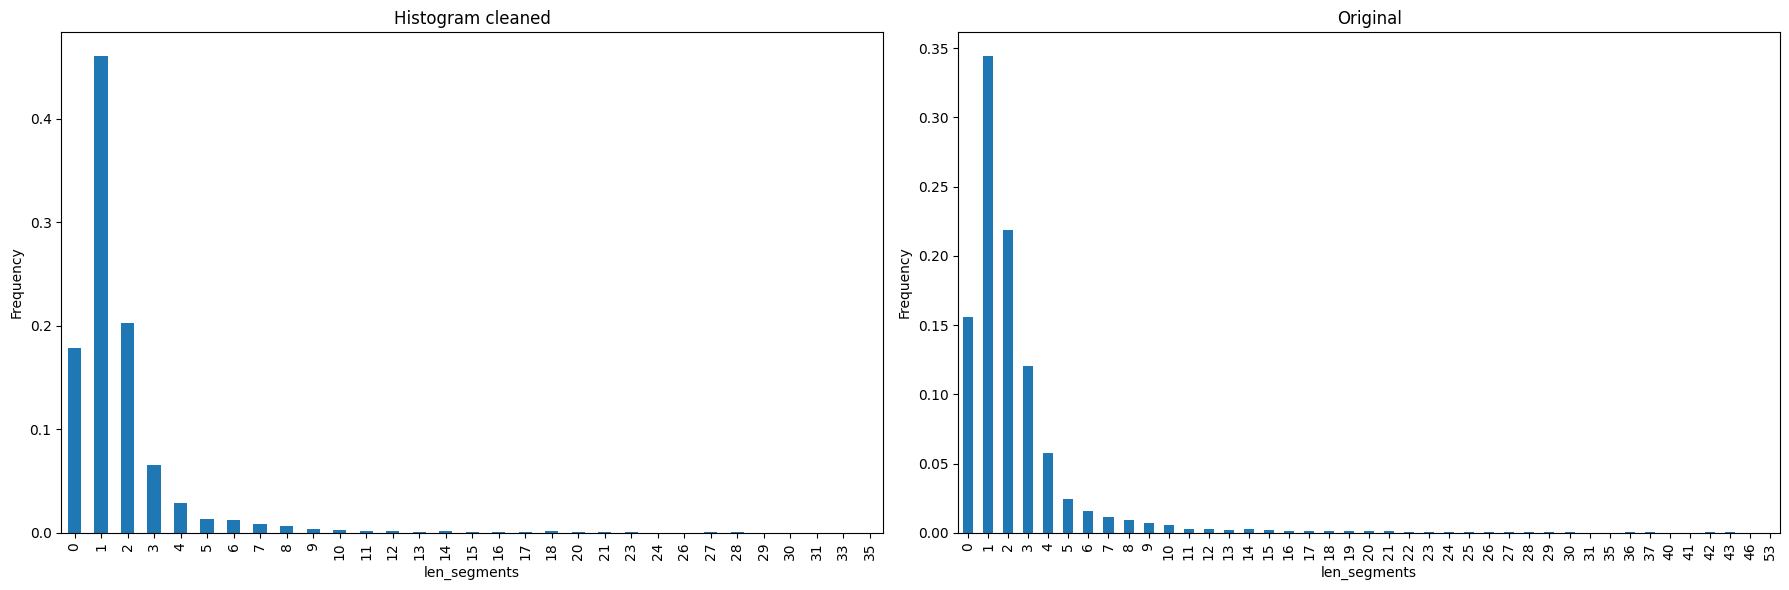

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot histogram for df_cleaned
histograme_cleaned = df_cleaned["len_segments"].value_counts().sort_index(ascending=True) / len(df_cleaned)
histograme_cleaned.plot(kind="bar", ax=axes[0], title="Histogram cleaned")
axes[0].set_ylabel("Frequency")

# Plot histogram for df_segments (assuming df_segments exists)
histograme_segments = df_original["len_segments"].value_counts().sort_index(ascending=True) / len(df_original)
histograme_segments.plot(kind="bar", ax=axes[1], title="Original")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Building Complete CSV

### Utilies functions

In [4]:
def nettoyer_reponse(reponse):
    if isinstance(reponse, list):
        reponse = " ".join(reponse)  # join the list into a single string
    reponse = re.sub(r"[{}.\[\]]", " ", reponse)  # enlever ponctuation spéciale
    reponse = re.sub(r"[^a-zA-Zàèéìòùç\s]", "", reponse)  # garder que les lettres et espaces
    mots = reponse.lower().split()
    return mots

# Calculer une similarité basique
def similarite(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Appliquer la logique de correction
def corriger_segments(row):
    try:
        segments = ast.literal_eval(row["segments"])
    except:
        return []
    
    mots_ref = nettoyer_reponse(row["config_list"])

    if len(segments) < 12:
        return []  # trop court, on ignore
    elif len(segments) == 12:
        return segments  # parfait

    # Si trop de mots, garder les 12 plus proches
    mots_whisper = [mot[0].lower() for mot in segments]

    scores = []
    for i, mot_w in enumerate(mots_whisper):
        score_total = sum(similarite(mot_w, mot_ref) for mot_ref in mots_ref)
        scores.append((i, score_total))

    # Garder les 12 meilleurs mots (plus cohérents avec la phrase attendue)
    meilleurs = sorted(scores, key=lambda x: x[1], reverse=True)[:12]
    indices_gardes = sorted([i for i, _ in meilleurs])  # trier pour garder l'ordre

    segments_corriges = [segments[i] for i in indices_gardes]
    return segments_corriges


def build_config_list(df_original):
    df_ref = df_original.copy()
    df_ref['config_list'] = df_original['config'].apply(lambda x: x.split(';'))
    df_ref = df_ref[['file_name', 'config_list']] # build csv keep only file name and config_list
    return df_ref

def remplace_by_references(row):
    try:
        # 'segments' might still be a string, so keep literal_eval here
        segments = ast.literal_eval(row["segments"]) if isinstance(row["segments"], str) else row["segments"]
        
        # 'config_list' is already a list
        config_words = row["config_list"]

        if len(segments) != len(config_words):
            return None  # lengths mismatch

        return [[ref_word, seg[1]] for ref_word, seg in zip(config_words, segments)]
    
    except Exception as e:
        print(f"Error in row {row.get('file_name', 'N/A')}: {e}")
        return None

In [ ]:
df_whisper = pd.read_csv("medium_cleaned_lolo.csv") 
file = "/Users/melina/Desktop/Hackathon/Hackathon_ASR/1_Ground_truth/Decoding_ground_truth_IT.csv"
df_original = pd.read_csv(file)

In [187]:
df_whisper = pd.read_csv("Segment_medium_IT_cleaned.csv")
df = df_whisper.copy()
df_ref = build_config_list(df_original)
df["config_list"] = df_ref["config_list"] # fuse the two dataframes
# df["filtered_segments"] = df.apply(corriger_segments, axis=1) # filtered using the config_list
# df["len_filtered_segments"] = df["filtered_segments"].apply(len) 
df["aligned_segments"] = df.apply(remplace_by_references, axis=1) # replace

In [188]:
df.to_csv("filtered_with_labels.csv", index=False)

In [5]:
# transcribe audio with 'medium' whisper 
def transcribe_single_audio(wav_file, language):
    model = whisper.load_model("small")
    result = model.transcribe(str(wav_file), word_timestamps=True, language=language)
    word_segments = []
    for segment in result["segments"]:
        for word in segment.get("words", []):
            word_segments.append([
                word["word"].strip(),
                [round(word["start"], 2), round(word["end"], 2)]
            ])
    return word_segments

## Pipeline from .wav to words

In [6]:
# match .wav to line in the df
def match_wav_to_line(wav_file, df):
    file_name = os.path.basename(wav_file)
    matched_row = df[df['file_name'] == file_name] # get the row with the same file name
    return matched_row

def replace_whisper_words_with_reference(final_words, reference_words):
    """
    Replace the words in final_words with the corresponding words in reference_words.
    """
    for i, (word, _) in enumerate(final_words):
        if i < len(reference_words):
            final_words[i][0] = reference_words[i]
    return final_words

In [9]:
# from .wav file apply pipeline
wav_file = "/Users/melina/Desktop/Hackathon/Hackathon_ASR/2_Audiofiles/Decoding_IT_T1/102_edugame2023_32c4a5e851c1431aba3aa409e3be8128_649d404f44214261b67b24f1845e1350.wav"
language = "it"

file = "/Users/melina/Desktop/Hackathon/Hackathon_ASR/1_Ground_truth/Decoding_ground_truth_IT.csv"
file = "/Users/melina/Desktop/Hackathon/Lemanic-Life-Sciences-Hackathon-2025/interface_data.csv"
df_original = pd.read_csv(file)

In [8]:
words = transcribe_single_audio(wav_file, language)


/Users/melina/.virtualenvs/base/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [10]:
words

[['All', [0.0, 0.22]],
 ["'ultima", [0.22, 0.62]],
 ['pagina', [0.62, 1.3]],
 ['nostro', [5.02, 5.72]],
 ['Bismaggo', [8.12, 9.52]],
 ['sir', [9.52, 10.18]],
 ['sir', [10.18, 11.2]],
 ['velone', [11.2, 11.94]],
 ['che', [11.94, 13.1]],
 ['dinare', [13.1, 15.62]],
 ['d', [15.62, 16.84]],
 ["'orca", [16.84, 17.42]],
 ['bolleggio', [19.2, 20.16]],
 ['Caglietapo', [23.86, 25.26]],
 ['Nacchipante', [28.2, 29.6]],
 ['Nutto', [32.1, 33.5]],
 ['Egnomisa', [34.26, 35.44]],
 ['Non', [35.44, 36.86]],
 ['grasso', [36.86, 38.96]],
 ['Le', [41.7, 42.4]],
 ['sciacope', [42.4, 43.14]]]

In [11]:
df_ref = build_config_list(df_original)           # build csv with only file name and target words
matched_row = match_wav_to_line(wav_file, df_ref) # get the row with the same file name

In [12]:
df_ref

,file_name,config_list
0,1001_edugame2023_59aa8ecf74c44db2adf56d71d1705...,"[vuso, seca, clofeno, ranviglio, dape, tarse, ..."
1,1001_edugame2023_59aa8ecf74c44db2adf56d71d1705...,"[istro, bismoggo, sirfelone, chetinare, borte,..."
2,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[strage, minestra, appartamento, caposcuola, t..."
3,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[diva, notte, barile, basilico, radio, anca, c..."
4,1001_edugame2023_e0304994bb364a74a1068abe1c1c0...,"[caso, fame, vicino, domenica, meno, bava, nuv..."
...,...,...
927,dummy_TEST_e584e972ac3146a2aea4c74e166d218c_55...,"[valo, save, clofelo, sonviglio, dete, farde, ..."
928,dummy_TEST_e883027f988444ec800dd7309e94515c_05...,"[ustro, bismacco, sarvelone, chetinere, binca,..."
929,dummy_TEST_e883027f988444ec800dd7309e94515c_fe...,"[valo, save, clofelo, sonviglio, dete, farde, ..."
930,dummy_TEST_f6c4713dbeac4a439367228aaa791c41_17...,"[ustro, bismacco, sarvelone, chetinere, binca,..."


In [13]:
cleaned_words = clean_output(words) # takes care of punctuation, stutter, repetition and concatenation

In [14]:
cleaned_words

[['All', [0.0, 0.22]],
 ["'ultima", [0.22, 0.62]],
 ['pagina', [0.62, 1.3]],
 ['nostro', [5.02, 5.72]],
 ['Bismaggo', [8.12, 9.52]],
 ['sir', [10.18, 11.2]],
 ['velone', [11.2, 11.94]],
 ['che', [11.94, 13.1]],
 ['dinare', [13.1, 15.62]],
 ["d'orca", [15.62, 17.42]],
 ['bolleggio', [19.2, 20.16]],
 ['Caglietapo', [23.86, 25.26]],
 ['Nacchipante', [28.2, 29.6]],
 ['Nutto', [32.1, 33.5]],
 ['Egnomisa', [34.26, 35.44]],
 ['Non', [35.44, 36.86]],
 ['grasso', [36.86, 38.96]],
 ['Lesciacope', [41.7, 43.14]]]

In [15]:
final_words = correct_segments(cleaned_words, matched_row["config_list"].values[0]) #  adapts guessed words using targets

In [16]:
final_words

[['nostro', [5.02, 5.72]],
 ['Bismaggo', [8.12, 9.52]],
 ['velone', [11.2, 11.94]],
 ['dinare', [13.1, 15.62]],
 ["d'orca", [15.62, 17.42]],
 ['bolleggio', [19.2, 20.16]],
 ['Caglietapo', [23.86, 25.26]],
 ['Nacchipante', [28.2, 29.6]],
 ['Nutto', [32.1, 33.5]],
 ['Egnomisa', [34.26, 35.44]],
 ['grasso', [36.86, 38.96]],
 ['Lesciacope', [41.7, 43.14]]]

In [17]:
replaced_words = replace_whisper_words_with_reference(final_words, matched_row["config_list"].values[0]) # replace guessed words with target words

In [18]:
# dataframe of a single line : file_name and final_words
df_final = pd.DataFrame({
    "file_name": [os.path.basename(wav_file)],
    "final_words": [replaced_words]
})

In [19]:
df_final

,file_name,final_words
0,102_edugame2023_32c4a5e851c1431aba3aa409e3be81...,"[[ostro, [5.02, 5.72]], [bismaggo, [8.12, 9.52..."


In [20]:
# save the replaced words to the CSV file
output_csv = "final_words.csv"
df_final.to_csv(output_csv, index=False)

In [2]:
import pandas as pd
file = "/Users/melina/Desktop/Hackathon/Hackathon_ASR/1_Ground_truth/Phoneme_Deleletion_ground_truth_FR.csv"
df_old = pd.read_csv(file)
df_new = df_old.copy()
# keep only file_name and config_list
df_new = df_new[["file_name", "config_id", "config", "API_target"]]

In [3]:
df_new.head(2)

,file_name,config_id,config,API_target
0,3101_edugame2023_1c148def3c254026adc7a7fdc3edc...,phondel_B_pseudo_8,bromal,[ʁɔmal]
1,3101_edugame2023_1c148def3c254026adc7a7fdc3edc...,phondel_B_pseudo_6,banéon,[aneɔ̃]


In [4]:
output_csv = "interface_data_FR.csv"

df_new.to_csv(output_csv, index=False)